# Sacred Cycles
*Simulating Menstrual-esque Cycles Using Injected Estrogen*

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import math
import numpy as np
import pandas as pd
from scipy.misc import derivative

%matplotlib inline
from matplotlib import pyplot as plt

import injectio

## Injection Curves

In [2]:
def normalizeInjection(ef, ef_dose):
    ef_norm = lambda T: ef(T) / ef_dose
    ef_norm.domain = ef.domain
    return ef_norm

# Estradiol Cypionate 1.0mg
# https://en.wikipedia.org/wiki/Template:Hormone_levels_with_estradiol_cypionate_by_intramuscular_injection#/media/File:Estradiol_levels_after_a_single_intramuscular_injection_of_1.0_to_1.5-mg_estradiol_cypionate_in_hypogonadal_girls.png
ec_level_1mg = np.array([
    [-1.0, 0.0],
    [0.0, 0.0],
    [2.0, 50.0],
    [3.0, 62.0],
    [4.0, 65.0],
    [5.0, 65.0],
    [6.0, 63.0],
    [7.0, 59.0],
    [10.0, 45.0],
    [11.0, 39.0],
    [13.0, 28.0],
    [14.0, 25.0],
    [15.0, 23.0],
    [18.0, 19.0],
    [20.0, 17.0],
    [37.0, 0.0],
    [38.0, 0.0]]);
ef_ec_1mg = injectio.rawDVToFunc(ec_level_1mg)

# Estradiol Cypionate 5.0mg
#https://en.wikipedia.org/wiki/Template:Hormone_levels_with_estradiol_valerate_by_intramuscular_injection#/media/File:Estradiol_levels_after_a_single_5_mg_intramuscular_injection_of_estradiol_esters.png
ec_level_5mg = np.array([
    [-1.0, 0.0],
    [0.0, 0.0],
    [1.0, 80.0],
    [2.0, 230.0],
    [2.1, 230.0], # control point
    [3.0, 210.0],
    [3.8, 220.0], # control point
    [4.0, 230.0],
    [4.4, 330.0],
    [4.5, 315.0], # control point
    [5.0, 225.0],
    [6.0, 185.0],
    [7.0, 175.0],
    [8.0, 155.0],
    [9.0, 115.0],
    [10.0, 100.0],
    [11.0, 90.0],
    [12.0, 80.0],
    [13.0, 55.0],
    [14.0, 45.0],
    [24.0, 0.0],
    [25.0, 0.0]]);
ef_ec_5mg = injectio.rawDVToFunc(ec_level_5mg)
ef_ec_5mg_norm = normalizeInjection(ef_ec_5mg, 5.0)

# Estradiol Valerate 5.0mg
# https://en.wikipedia.org/wiki/Template:Hormone_levels_with_estradiol_valerate_by_intramuscular_injection#/media/File:Estradiol_levels_after_a_single_5_mg_intramuscular_injection_of_estradiol_esters.png
ev_level_5mg = np.array([
    [-1.0, 0.0],
    [0.0, 0.0],
    [0.5, 160.0],
    [2.0, 610.0],
    [2.5, 675.0],
    [3.0, 515.0],
    [4.0, 310.0],
    [5.0, 210.0],
    [6.0, 115.0],
    [7.0, 70.0],
    [8.0, 60.0],
    [9.0, 45.0],
    [10.0, 35.0],
    [11.0, 20.0],
    [12.0, 15.0],
    [13.0, 10.0],
    [21.0, 0.0],
    [22.0, 0.0]]);
ef_ev_5mg = injectio.rawDVToFunc(ev_level_5mg)
ef_ev_5mg_norm = normalizeInjection(ef_ev_5mg, 5.0)

## Optimization

This constructs an optimization problem solving for optimal injection doses and times to fit a desired blood level profile.

In [26]:
from scipy.optimize import least_squares, differential_evolution, Bounds

def calcInjection(T, injections):
    level = 0.0
    for inj_date, inj in injections.items():
        (inj_ratio, inj_ef) = inj
        level += inj_ratio * inj_ef(timeDeltaToDays(T - inj_date))
    return level

def newDoses(injections, doses):
    for i in range(len(injections.array)-1):
        injections.array[i] = (doses[i], injections.array[i][1])

def newDosesTimes(injections, doses_times):
    n_inj = len(injections)-1
    doses = doses_times[0:n_inj]
    times = doses_times[n_inj:]

    old_times = [timeDeltaToDays(T) for T in (injections.index - injections.index[0])]
    old_times[0:n_inj] = times
    new_times = pd.to_datetime([injections.index[0] + pd.to_timedelta(T, unit='D') for T in old_times])
    
    newDoses(injections, doses)
    injections.set_axis(new_times, inplace=True)
    
# This doesn't include the final dummy injection! Which is fine for the purpose
# of the optimization function, but the resulting injections Series won't
# behave as expected elsewhere.
def createInjectionsDosesTimes(doses_times, inj_ef):
    n_inj = int(doses_times.size / 2)
    doses = doses_times[0:n_inj]
    times = doses_times[n_inj:]
    return pd.Series([(d, inj_ef) for d in doses], index=pd.to_datetime(times, unit='D'))
    
def createInitialAndBounds(injections, max_dose=np.inf, time_bounds='midpoints'):
    doses = np.array([inj[0] for inj_date,inj in injections.items()][:-1])
    times = np.array([injectio.timeDeltaToDays(inj_date - injections.index[0]) for inj_date in injections.index][:-1])
    dose_bounds = [(0.0, max_dose)]*len(doses)
    
    if time_bounds == 'midpoints':
        # Midpoint time bound handling:
        #   The first injection's minimum time bound is 0.0
        #   The last injection's maximum time bound is the dummy injection time
        #   All other bounds are at the midpoints between the initial times
        midpoints = (times[1:] + times[:-1])/2.0
        #time_bounds = [(0.0, midpoints[0])] +\
        #TODO: revert this after figuring out zeroLevelsFromInjections flooring inconsistency
        time_bounds = [(0.0, np.nextafter(0.0, 1.0))] +\
                      [(l, r) for l,r in zip(midpoints[:-1], midpoints[1:])] +\
                      [(midpoints[-1], injectio.timeDeltaToDays(injections.index[-1] - injections.index[0]))]
    elif time_bounds == 'fixed':
        # least_squares doesn't have in-built capacity for fixed parameters,
        # and also requires each lower bound to be strictly less than each
        # upper bound. This is basically a hack to avoid requiring different
        # implementations for optimizing on doses+times vs just doses, keeping
        # the same array X of independent variables in both cases.
        time_bounds = [(T, np.nextafter(T, T+1.0)) for T in times]
    else:
        raise ValueError(f"'{time_bounds}' isn't a recognized input for time_bounds")
        
    return np.concatenate((doses, times)),\
           list(zip(*dose_bounds, *time_bounds))


# X is a 1D array of injection parameters we optimize on.
# Let i_n == len(injections)-1 (The last injection is always a zero-dose dummy
# point, so we don't optimize on it).
# Then, X is represented as i_n dose values followed by i_n corresponding dates
# in days.
# So, len(X) == 2*i_n.

def fDosesAndTimes(X_doses_times, inj_ef, target_x, target_y):
    injections = createInjectionsDosesTimes(X_doses_times, inj_ef)
    residuals = pd.Series(np.zeros(len(target_x)), index=target_x)
    injectio.calcInjections(residuals, injections)
    residuals -= target_y
    return residuals

def callback(xk, convergence=0.0):
    print(xk)

### Data to fit

In [27]:
target_fun = lambda T: int(T>=pd.to_datetime('1970-02-01')) * (250.0 + 50.0*np.sin(0.5*injectio.timeDeltaToDays(T - target_x[0])+9.59)) +\
                       int(T<pd.to_datetime('1970-02-01'))  * (8.0*injectio.timeDeltaToDays(T - target_x[0]))
target_x = pd.date_range(0, pd.to_datetime(62.0, unit='D'), freq='6H')
target_y = np.array([target_fun(T) for T in target_x])

In [16]:
# The other kind of optimization... Performance!

import timeit

def fDosesAndTimes2(X_doses_times, inj_ef, target_x, target_y):
    injections = createInjectionsDosesTimes(X_doses_times, inj_ef)
    residuals = pd.Series(-1.0*target_y, index=target_x)
    injectio.calcInjections(residuals, injections)
    return residuals

injections = injectio.createInjectionsCycle(ef_ec_1mg, 62.0, '3D')
X0, bounds = createInitialAndBounds(injections, 5.0, time_bounds='fixed')

n = 100
injections = createInjectionsDosesTimes(X0, ef_ec_1mg)
residuals = pd.Series(np.zeros(len(target_x)), index=target_x)
print(timeit.timeit(lambda: fDosesAndTimes(X0, ef_ec_1mg, target_x, target_y), number=n) / n)
print(timeit.timeit(lambda: fDosesAndTimes2(X0, ef_ec_1mg, target_x, target_y), number=n) / n)

0.1144488284900001
0.1186640033599997


### Least Squares (Estradiol Cypionate, optimizing doses)

Works ok, doesn't find a great solution right now.

In [31]:
injections = injectio.createInjectionsCycle(ef_ec_1mg, 62.0, '3D')
X0, bounds = createInitialAndBounds(injections, max_dose=5.0, time_bounds='fixed')
result = least_squares(fDosesAndTimes, X0,
                       args=(ef_ec_1mg, target_x, target_y),
                       bounds=bounds,
                       max_nfev=35,
                       verbose=2)
print(result)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.1512e+05                                    3.64e+05    
       1              2         1.5695e+05      5.58e+05       8.84e-01       1.37e+05    
       2              3         6.6711e+04      9.02e+04       5.85e-01       4.85e+04    
       3              4         5.1118e+04      1.56e+04       2.89e-01       1.39e+05    
       4              5         4.6252e+04      4.87e+03       1.18e-01       6.43e+04    
       5              6         3.0809e+04      1.54e+04       5.45e-01       1.14e+05    
       6              7         2.7486e+04      3.32e+03       9.15e-02       2.26e+04    
       7              8         2.3201e+04      4.28e+03       1.66e-01       7.87e+04    
       8              9         2.1972e+04      1.23e+03       7.34e-02       2.40e+04    
       9             10         1.9300e+04      2.67e+03       1.86e-01       7.14e+04    

1970-01-01    (0.3502612554797075, CPUDispatcher(<function r...
1970-01-04    (0.37537909585237395, CPUDispatcher(<function ...
1970-01-07    (0.45039543860575065, CPUDispatcher(<function ...
1970-01-10    (0.5444452891358247, CPUDispatcher(<function r...
1970-01-13    (0.6145022352813861, CPUDispatcher(<function r...
1970-01-16    (0.6891735667651052, CPUDispatcher(<function r...
1970-01-19    (0.7892615999540636, CPUDispatcher(<function r...
1970-01-22    (0.8105046161616813, CPUDispatcher(<function r...
1970-01-25    (0.887906916527872, CPUDispatcher(<function ra...
1970-01-28    (1.0084788622580525, CPUDispatcher(<function r...
1970-01-31    (1.602585906253701, CPUDispatcher(<function ra...
1970-02-03    (0.48738398998870536, CPUDispatcher(<function ...
1970-02-06    (0.1418229459066503, CPUDispatcher(<function r...
1970-02-09    (0.6451732456259138, CPUDispatcher(<function r...
1970-02-12    (2.036516391280385, CPUDispatcher(<function ra...
1970-02-15    (0.5732665460830713, CPUDi

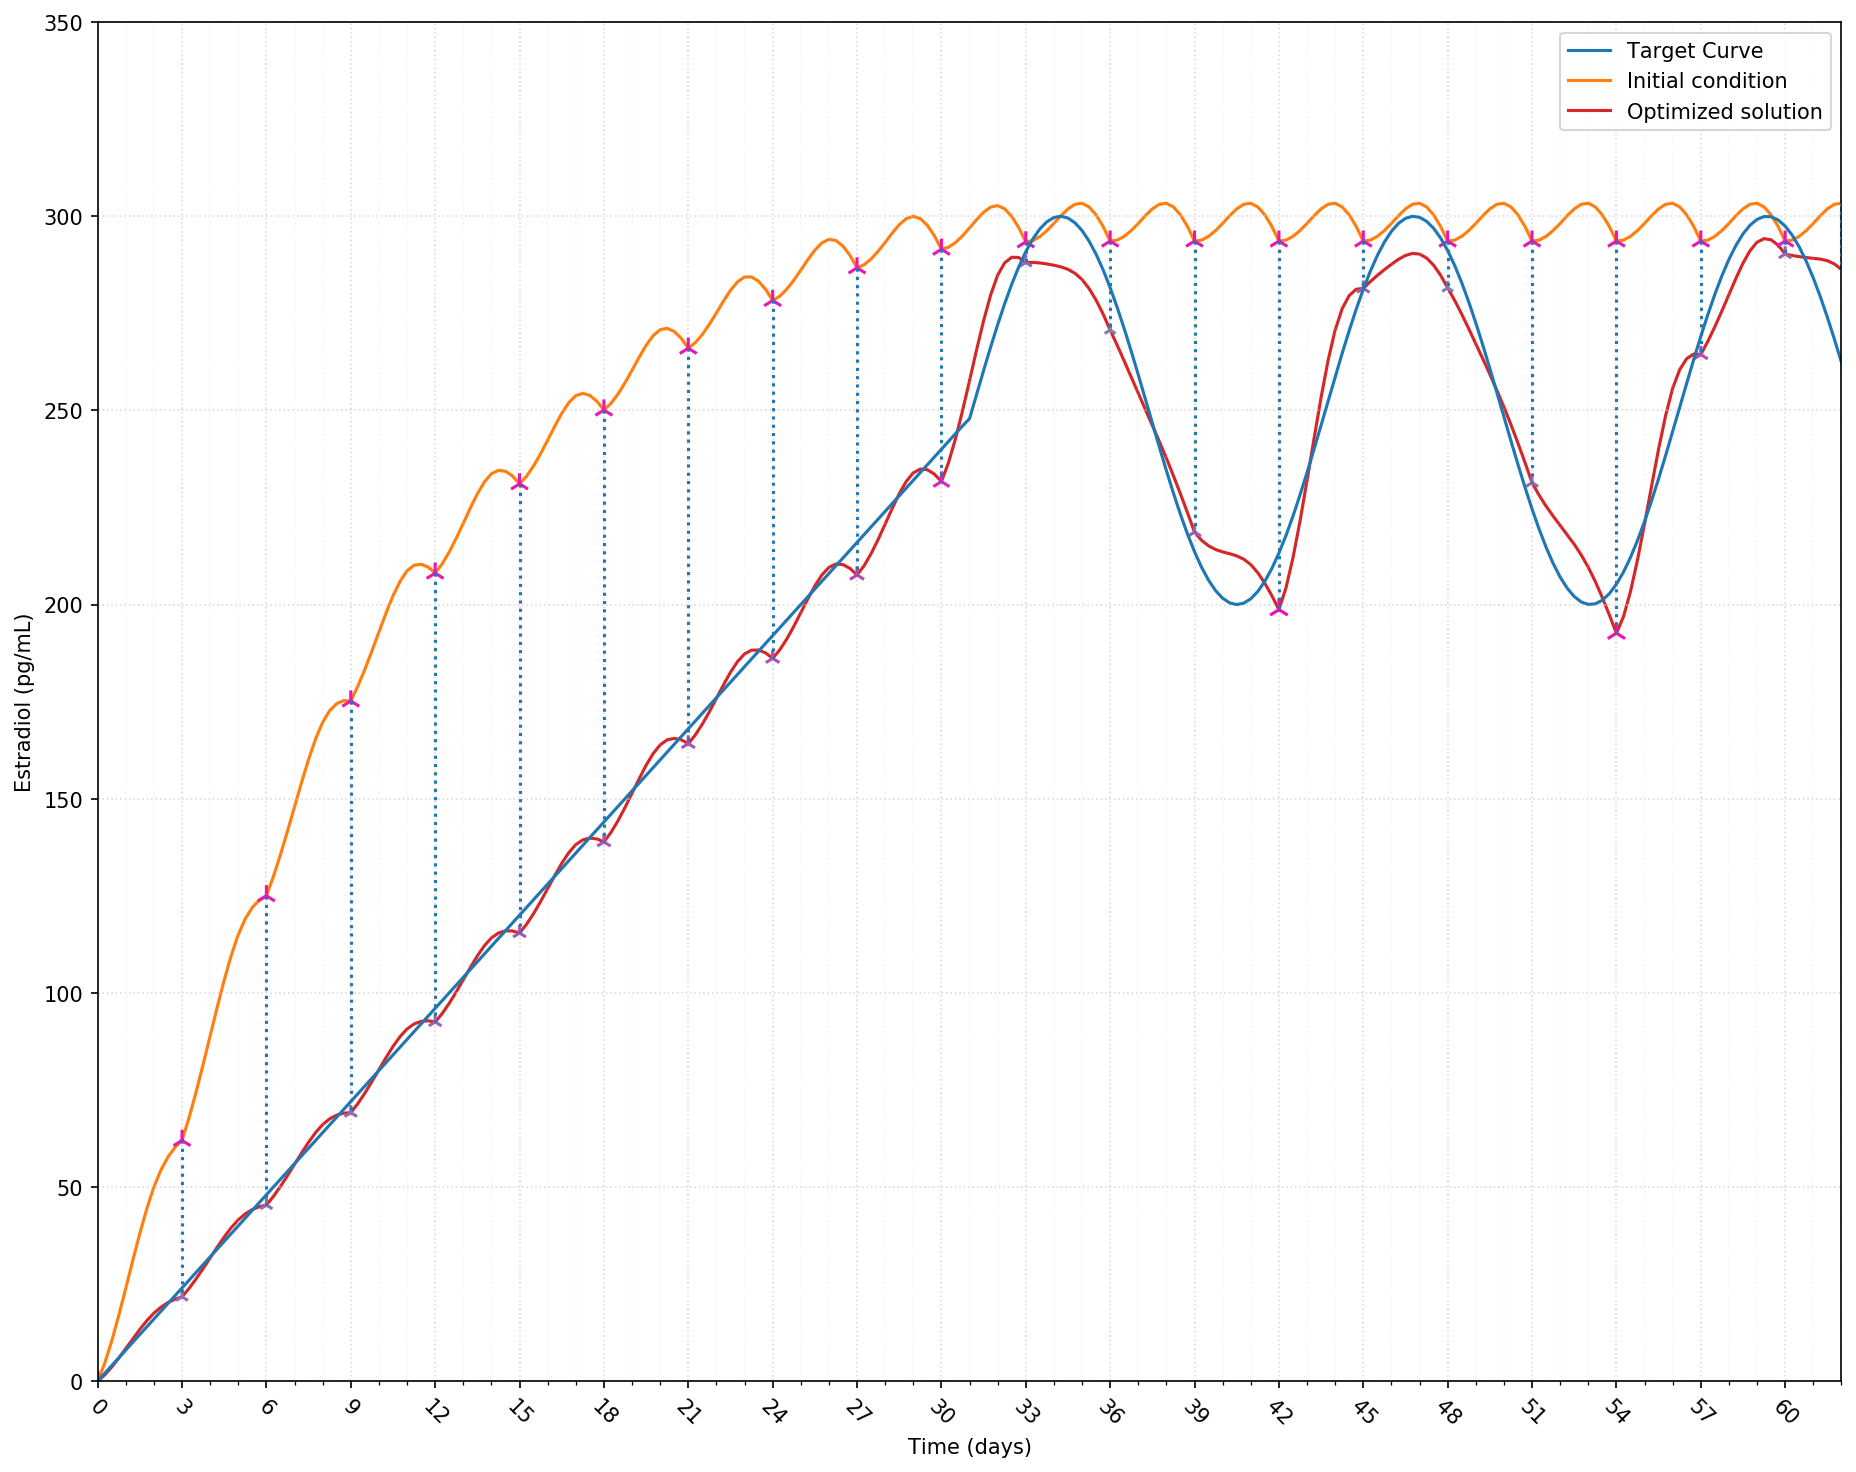

In [32]:
injections_init = injectio.createInjectionsCycle(ef_ec_1mg, 62.0, '3D')
start_y = injectio.calcInjections(pd.Series(np.zeros(len(target_x)), index=target_x), injections_init)
injections_optim = createInjectionsDosesTimes(result.x, ef_ec_1mg)
injections_optim[injections_init.index[-1]] = injections_init[-1]

with np.printoptions(precision=2, suppress=True):
    print(injections_optim)

init_levels = injectio.calcInjections(injectio.zeroLevelsAtInjections(injections_init),
                             injections_init)
init_points = [(injectio.timeDeltaToDays(T - init_levels.index[0]), d) for T,d in init_levels.items()]

optim_levels = injectio.calcInjections(injectio.zeroLevelsAtInjections(injections_optim),
                              injections_optim)
optim_points = [(injectio.timeDeltaToDays(T - init_levels.index[0]), d) for T,d in optim_levels.items()]

lines = list(zip(init_points, optim_points))

injectio.startPlot()
plt.ylim(bottom=0, top=350)
plt.yticks(range(0, 351, 50))
plt.plot([injectio.timeDeltaToDays(x - target_x[0]) for x in target_x], target_y, label="Target Curve")
injectio.plotInjections(injections_init, '6H', label="Initial condition")
injectio.plotInjections(injections_optim, '6H', label="Optimized solution")
from matplotlib import collections as mc
lc = mc.LineCollection(lines, linestyles='dotted', zorder=10)
plt.gca().add_collection(lc);
plt.legend();

### Least Squares (Estradiol Cypionate, Doses & Times)

This works awesome!

In [29]:
injections = injectio.createInjectionsCycle(ef_ec_1mg, 62.0, '3D')
X0, bounds = createInitialAndBounds(injections, max_dose=5.0, time_bounds='midpoints')
result = least_squares(fDosesAndTimes, X0,
                       args=(ef_ec_1mg, target_x, target_y),
                       xtol=None,
                       bounds=bounds,
                       max_nfev=30,
                       verbose=2)
print(result)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.1512e+05                                    3.64e+05    
       1              2         1.5501e+05      5.60e+05       8.87e-01       1.36e+05    
       2              3         6.3984e+04      9.10e+04       5.93e-01       4.77e+04    
       3              4         4.7841e+04      1.61e+04       2.95e-01       1.39e+05    
       4              5         4.2840e+04      5.00e+03       1.18e-01       6.10e+04    
       5              6         2.6832e+04      1.60e+04       5.60e-01       1.15e+05    
       6              7         2.3498e+04      3.33e+03       9.09e-02       2.11e+04    
       7              8         1.9348e+04      4.15e+03       1.71e-01       7.48e+04    
       8              9         1.8226e+04      1.12e+03       6.46e-02       2.23e+04    
       9             10         1.5559e+04      2.67e+03       2.02e-01       6.53e+04    

1970-01-01 00:00:00.000000000    (0.35663000042931337, CPUDispatcher(<function ...
1970-01-04 00:21:04.413801600    (0.38156527979856497, CPUDispatcher(<function ...
1970-01-07 00:57:41.604681600    (0.4563654675197281, CPUDispatcher(<function r...
1970-01-10 01:03:31.587580800    (0.5472912292207842, CPUDispatcher(<function r...
1970-01-13 00:58:00.242976000    (0.6170649919567168, CPUDispatcher(<function r...
1970-01-16 01:10:12.551836800    (0.6934392282483711, CPUDispatcher(<function r...
1970-01-19 00:48:48.385267199    (0.7759788669132068, CPUDispatcher(<function r...
1970-01-22 00:18:59.953132800    (0.8137304810744561, CPUDispatcher(<function r...
1970-01-25 00:54:16.911417600    (0.9192633261629088, CPUDispatcher(<function r...
1970-01-28 01:56:31.814332800    (1.0502746477024065, CPUDispatcher(<function r...
1970-01-31 02:20:57.275491200    (1.4922586778704605, CPUDispatcher(<function r...
1970-02-02 14:51:00.391564800    (0.5414398408846849, CPUDispatcher(<function r...
1970

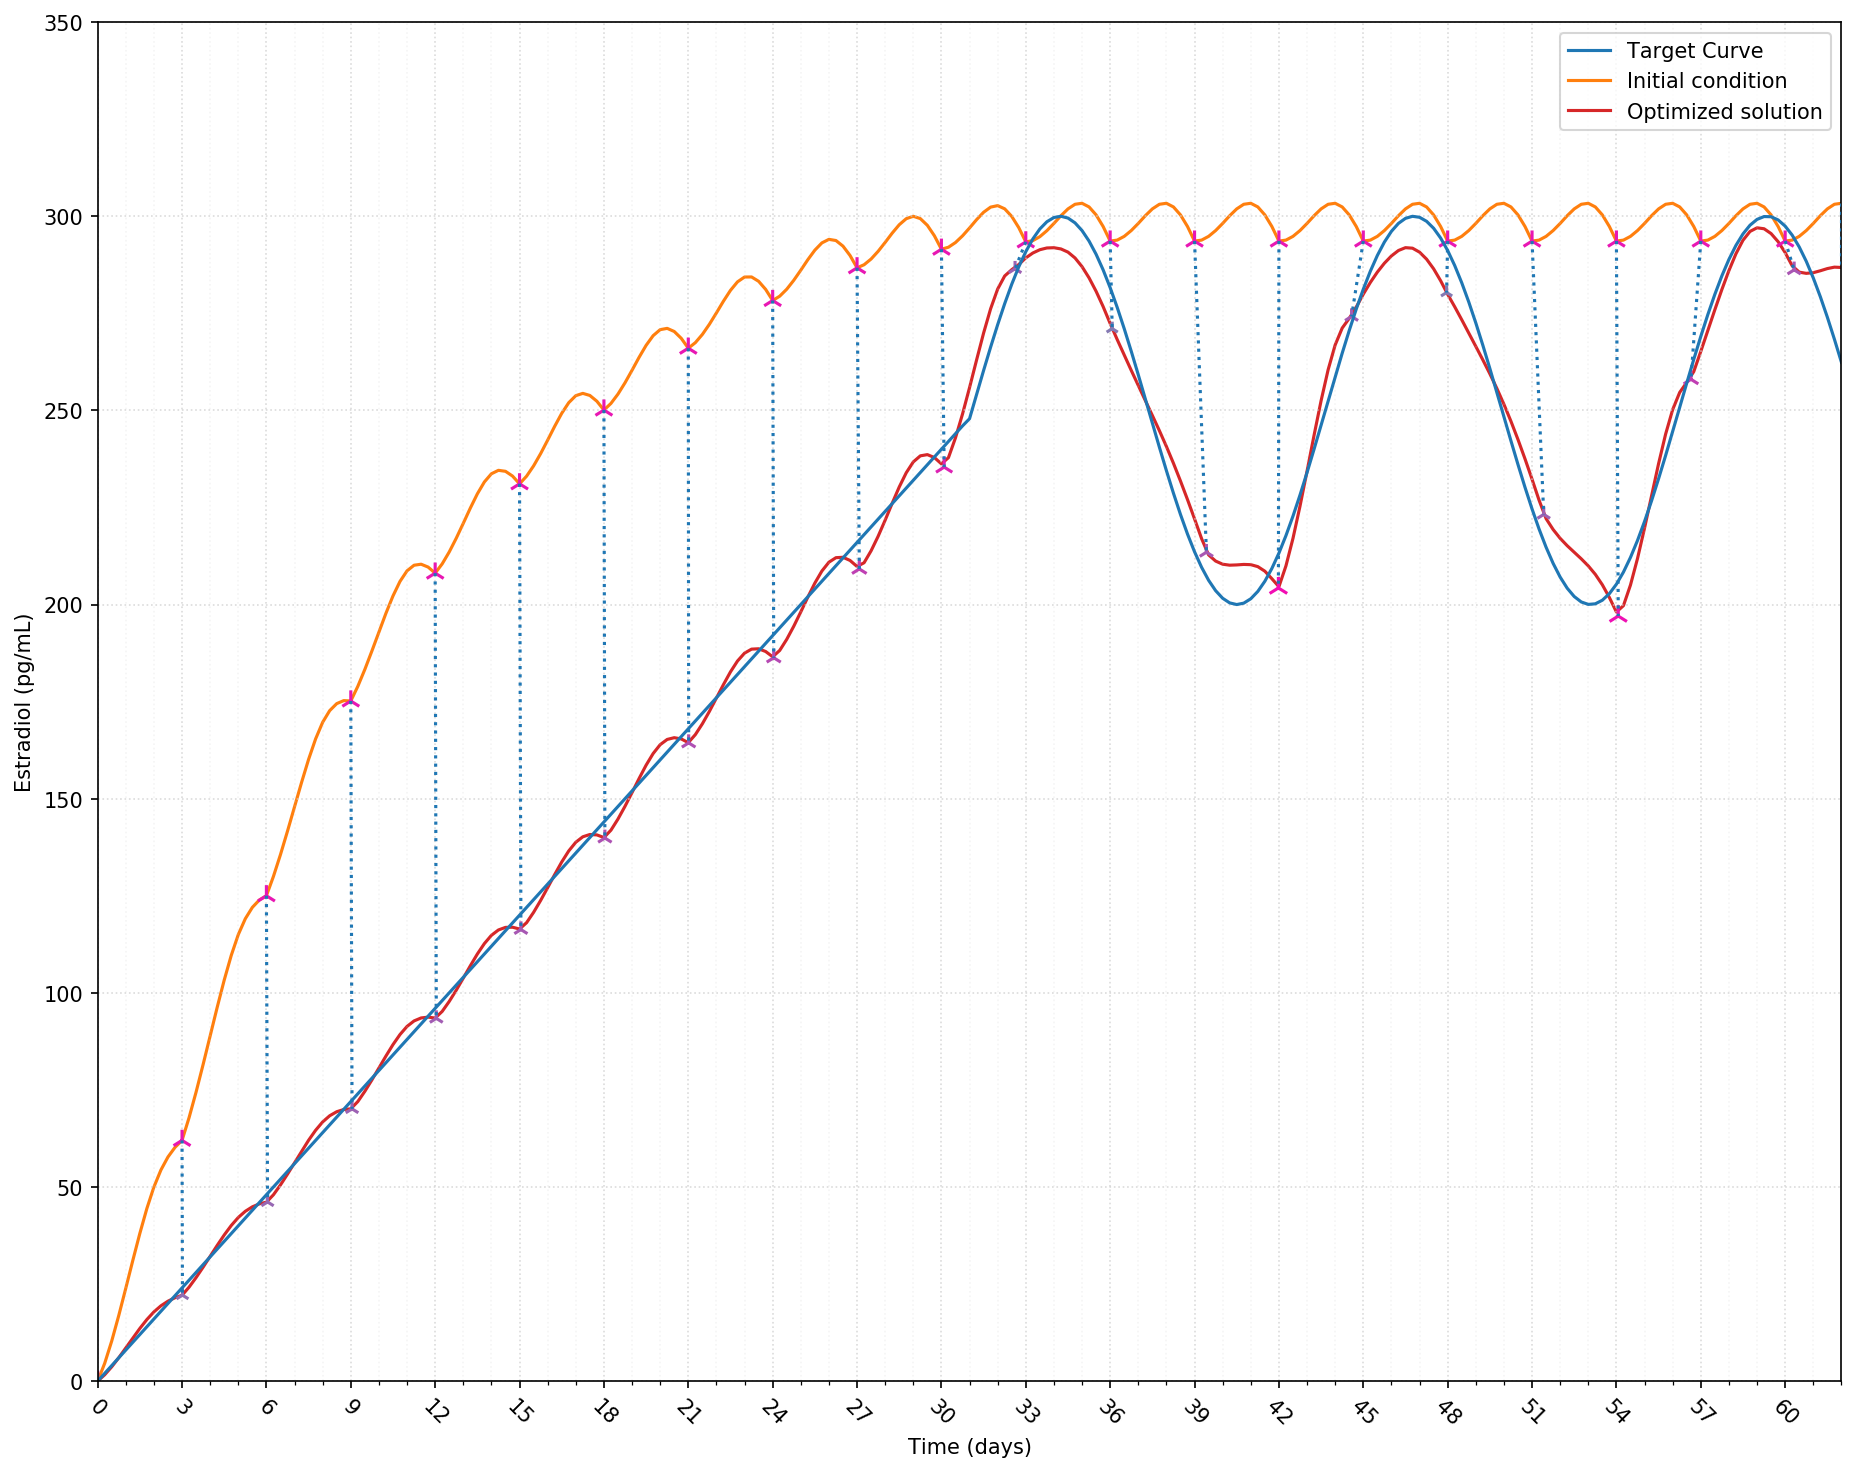

In [30]:
injections_init = injectio.createInjectionsCycle(ef_ec_1mg, 62.0, '3D')
start_y = injectio.calcInjections(pd.Series(np.zeros(len(target_x)), index=target_x), injections_init)
injections_optim = createInjectionsDosesTimes(result.x, ef_ec_1mg)
injections_optim[injections_init.index[-1]] = injections_init[-1]

with np.printoptions(precision=2, suppress=True):
    print(injections_optim)

init_levels = injectio.calcInjections(injectio.zeroLevelsAtInjections(injections_init),
                             injections_init)
init_points = [(injectio.timeDeltaToDays(T - init_levels.index[0]), d) for T,d in init_levels.items()]

optim_levels = injectio.calcInjections(injectio.zeroLevelsAtInjections(injections_optim),
                              injections_optim)
optim_points = [(injectio.timeDeltaToDays(T - init_levels.index[0]), d) for T,d in optim_levels.items()]

lines = list(zip(init_points, optim_points))

injectio.startPlot()
plt.ylim(bottom=0, top=350)
plt.yticks(range(0, 351, 50))
plt.plot([injectio.timeDeltaToDays(x - target_x[0]) for x in target_x], target_y, label="Target Curve")
injectio.plotInjections(injections_init, '6H', label="Initial condition")
injectio.plotInjections(injections_optim, '6H', label="Optimized solution")
from matplotlib import collections as mc
lc = mc.LineCollection(lines, linestyles='dotted', zorder=10)
plt.gca().add_collection(lc);
plt.legend();

### Least Squares (Estradiol Valerate, Doses & Times)

At reasonable injection schedules, EV just really doesn't work for doing any kind of cycling. You can do it alright if you inject more frequently than the single-dose peak ($\tau \lt t_{max}$), but the smoother curve of Estradiol Cypionate makes it more suitable for this use.

In [32]:
injections = injectio.createInjectionsCycle(ef_ev_5mg_norm, 62.0, '1D')
X0, bounds = createInitialAndBounds(injections, max_dose=5.0, time_bounds='midpoints')
result = least_squares(fDosesAndTimes, X0,
                       args=(ef_ev_5mg_norm, target_x, target_y),
                       bounds=bounds,
                       max_nfev=25,
                       verbose=2)
print(result)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         9.3120e+06                                    7.29e+05    
       1              2         1.5192e+06      7.79e+06       2.79e+00       1.77e+05    
       2              3         2.0304e+05      1.32e+06       1.29e+00       5.92e+04    
       3              4         3.0151e+04      1.73e+05       5.37e-01       8.30e+04    
       4              5         2.4363e+04      5.79e+03       1.45e-01       1.61e+04    
       5              6         8.8122e+03      1.56e+04       1.90e-01       5.76e+04    
       6              7         7.1507e+03      1.66e+03       6.53e-02       1.50e+04    
       7              8         4.5835e+03      2.57e+03       1.10e-01       1.31e+04    
       8              9         3.9249e+03      6.59e+02       4.35e-02       7.06e+03    
       9             10         2.6234e+03      1.30e+03       6.20e-02       1.89e+04    

1970-01-01 00:00:00.000000000    (0.10787086548356094, <function normalizeInjec...
1970-01-01 22:54:30.775190400    (0.07698035374986406, <function normalizeInjec...
1970-01-02 23:48:35.554579200    (0.08087246509746744, <function normalizeInjec...
1970-01-04 00:06:45.313804800    (0.10303038980800677, <function normalizeInjec...
1970-01-05 00:11:44.952547200    (0.1326080057603442, <function normalizeInject...
1970-01-06 00:13:05.981750400    (0.1489451720444436, <function normalizeInject...
1970-01-07 00:11:15.239760000    (0.16224621677452117, <function normalizeInjec...
1970-01-08 00:11:48.000566400    (0.1717923789629139, <function normalizeInject...
1970-01-09 00:12:09.583891200    (0.19369425104598062, <function normalizeInjec...
1970-01-10 00:12:43.655126400    (0.21389586112236403, <function normalizeInjec...
1970-01-11 00:09:20.240582400    (0.22620933539469806, <function normalizeInjec...
1970-01-12 00:09:19.965312000    (0.24349449264192713, <function normalizeInjec...
1970

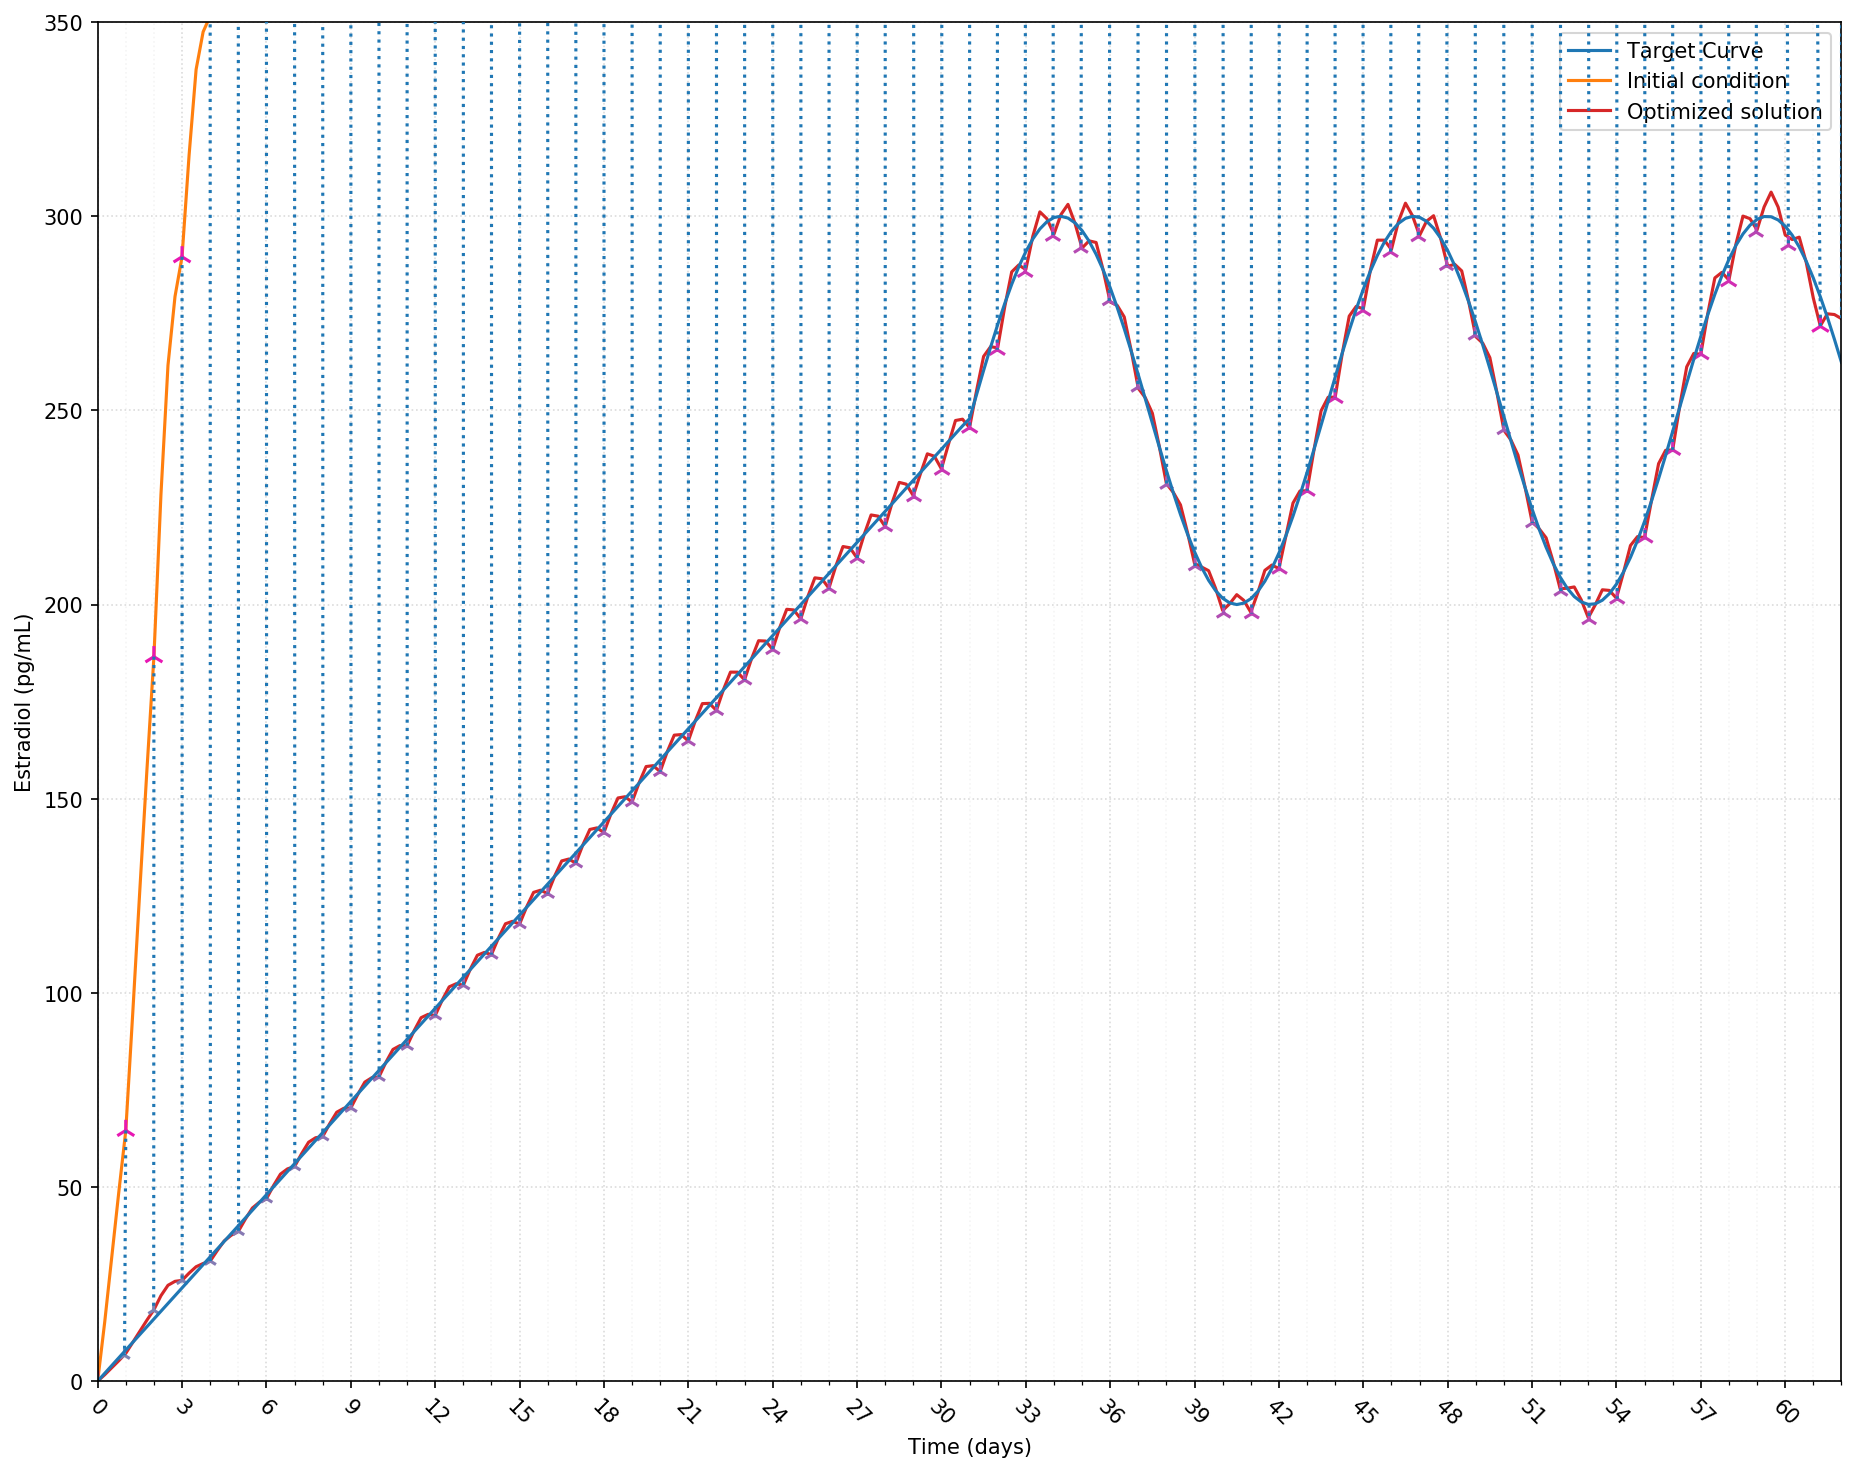

In [40]:
injections_init  = injectio.createInjectionsCycle(ef_ev_5mg_norm, 62.0, '1D')
injections_optim = createInjectionsDosesTimes(result.x, ef_ev_5mg_norm)
injections_optim[injections_init.index[-1]] = injections_init[-1]

with np.printoptions(precision=2, suppress=True):
    with pd.option_context('display.max_rows', sys.maxsize):
        print(injections_optim)

init_levels = injectio.calcInjections(injectio.zeroLevelsAtInjections(injections_init),
                             injections_init)
init_points = [(injectio.timeDeltaToDays(T - init_levels.index[0]), d) for T,d in init_levels.items()]

optim_levels = injectio.calcInjections(injectio.zeroLevelsAtInjections(injections_optim),
                              injections_optim)
optim_points = [(injectio.timeDeltaToDays(T - init_levels.index[0]), d) for T,d in optim_levels.items()]

lines = list(zip(init_points, optim_points))

injectio.startPlot()
plt.ylim(bottom=0, top=350)
plt.yticks(range(0, 351, 50))
plt.plot([injectio.timeDeltaToDays(x - target_x[0]) for x in target_x], target_y, label="Target Curve")
injectio.plotInjections(injections_init, '6H', label="Initial condition")
injectio.plotInjections(injections_optim, '6H', label="Optimized solution")
from matplotlib import collections as mc
lc = mc.LineCollection(lines, linestyles='dotted', zorder=10)
plt.gca().add_collection(lc);
plt.legend();

In [ ]:
"""
# Ok, scratch all that, path of least resistance.
# X[] is the array of all doses that are being optimzied on (the dose column
# of the injections array)
injections = createInjectionsCycle(ef_ec_1mg, 62.0, '3D')

target_x = pd.date_range(0, pd.to_datetime(62.0, unit='D'), freq='6H')
target_fun = lambda T: int(T>=pd.to_datetime('1970-02-01')) * (250.0 + 50.0*np.sin(0.5*timeDeltaToDays(T - target_x[0])+9.59)) +\
                       int(T<pd.to_datetime('1970-02-01'))  * (8.0*timeDeltaToDays(T - target_x[0]))
target_y = [target_fun(T) for T in target_x]
start_y = [calcInjection(T, injections) for T in target_x]
residuals_fun = lambda T: calcInjection(T, injections) - target_fun(T)
residuals = [residuals_fun(T) for T in target_x]


from scipy.optimize import least_squares, differential_evolution, Bounds


# Full residuals function
def fDoses(X_doses, injections, target_x, residuals_fun):
    newDoses(injections, X_doses)
    return [residuals_fun(T) for T in target_x]

X0 = [inj[0] for inj_date,inj in injections.items()][:-1]

#result=least_squares(f, X0,
#                     args=(injections, target_x, residuals_fun),
#                     bounds=(0.0, np.inf),
#                     verbose=2)
#print(result)
"""

#def fitInjections(...):
    # How to even model this?
    
    # Given: a target curve (ie menstrual-ish cycle) [Series of (T [date], E [pg/mL]) points]
    #      : a particular injectable curve function ef
    #      : a steady state injection cycle (or include this too in the curve to fit?)
    #      : bounds on dependent variables (ie min/max injection frequency)
    # Solve: a series of (T [date], dose [mg]) injections that best approximate the target curve (regressor variables)
    #      : a result curve modeling the best-fit approximation of the target curve using the fitted injections
    
    # I'm thinking:
    #   Starting from the most recent steady state, overlay the target curve.
    #   Then, using the – ah fuck! You can't just iterate in time... you need
    #   to look at least the next two future injections. Could think of the
    #   variables as "injection impact time window" and dose, aka: delay until
    #   next injection and dose. Well, if we look at the previous injection as
    #   being already fixed, then it's fine, and we actually look backwards
    #   first to determine the dose. Fuuuck this is complicated!
    
    # What if I fix the injection frequency and times and only vary the dose?
    # That's easier! Then it's just least squares.
    # At each injection, we are searching for the dose that best fits the target
    # curve ~for the time between this injection and the next one~.
    # Optimize each injection individually, then recompute all the following
    # injections, and continue to opimize the next injection, until every dose
    # has been optimized.
    
    # Yaaa optimizing the times is hellish, I'll pass. I want a nice and
    # consistent dosing schedule, anyways. So the question is how do i compute
    # errors for regression? OH i can just cheat and use a bruter-force
    # optimization algorithm.
    
    # OK! So. I need the full injections curve to be accessible as a function.
    # Functional interface to calcInjections... tricksy. Gonna be slow as shit LOL
    # Rigth now calcInjections works on a buffer, but it only needs to be this:

### Flat func (Estradiol Cypionate, optimize doses & times)

It's fun! This demonstrates the control theory intuition that, if desired, you can reach a steady state level more quickly by using several large injections to reach the target level and then reducing to a regular consistent dose. That doesn't mean it woul dbe good for your body! But, looking purely at blood concentration levels, it's possible. The lsq solution here achieves a 150pg/mL change in level, steady-to-steady, in just 9 days (in comparison to 6 weeks for a linear, consistent increase in dose.

In [25]:
flat_fun = lambda T: int(T>=pd.to_datetime('1970-02-01')) * (250.0) +\
                       int(T<pd.to_datetime('1970-02-01'))  * (100.0)
flat_x = pd.date_range(0, pd.to_datetime(62.0, unit='D'), freq='6H')
flat_y = np.array([flat_fun(T) for T in flat_x])

In [26]:
injections = injectio.createInjectionsCycle(ef_ec_1mg, 62.0, '3D')
X0, bounds = createInitialAndBounds(injections, max_dose=1.5, time_bounds='midpoints')
result = least_squares(fDosesAndTimes, X0,
                       args=(ef_ec_1mg, flat_x, flat_y),
                       xtol=None,
                       max_nfev=35,
                       bounds=bounds,
                       verbose=2)
print(result)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.3397e+06                                    5.22e+05    
       1              2         2.8948e+05      1.05e+06       1.10e+00       1.20e+05    
       2              3         1.3249e+05      1.57e+05       5.05e-01       5.53e+04    
       3              4         8.3132e+04      4.94e+04       4.40e-01       3.33e+04    
       4              5         7.2975e+04      1.02e+04       2.08e-01       1.94e+04    
       5              6         6.5860e+04      7.11e+03       1.62e-01       1.65e+04    
       6              7         6.2070e+04      3.79e+03       1.22e-01       1.22e+04    
       7              8         5.8477e+04      3.59e+03       1.24e-01       1.40e+04    
       8              9         5.6290e+04      2.19e+03       9.00e-02       9.82e+03    
       9             10         5.3951e+04      2.34e+03       1.10e-01       1.24e+04    

1970-01-01 00:00:00.000000000    (1.4813153823760576, CPUDispatcher(<function r...
1970-01-03 17:50:57.151132800    (0.15331392370454938, CPUDispatcher(<function ...
1970-01-07 01:22:35.508374400    (0.23517526014384535, CPUDispatcher(<function ...
1970-01-10 00:30:23.234140800    (0.409570479294853, CPUDispatcher(<function ra...
1970-01-12 22:13:56.230896000    (0.3500313701065995, CPUDispatcher(<function r...
1970-01-16 00:17:46.734835200    (0.28972693634642765, CPUDispatcher(<function ...
1970-01-18 23:20:33.999072000    (0.2962493715260419, CPUDispatcher(<function r...
1970-01-22 02:02:32.445427200    (0.3081693328430502, CPUDispatcher(<function r...
1970-01-25 03:41:24.704851200    (0.33119572326035945, CPUDispatcher(<function ...
1970-01-29 05:18:12.460233600    (1.2386643165815472, CPUDispatcher(<function r...
1970-01-30 18:59:56.796316800    (1.491053718631397, CPUDispatcher(<function ra...
1970-02-02 10:30:18.851443200    (0.7385997266770256, CPUDispatcher(<function r...
1970

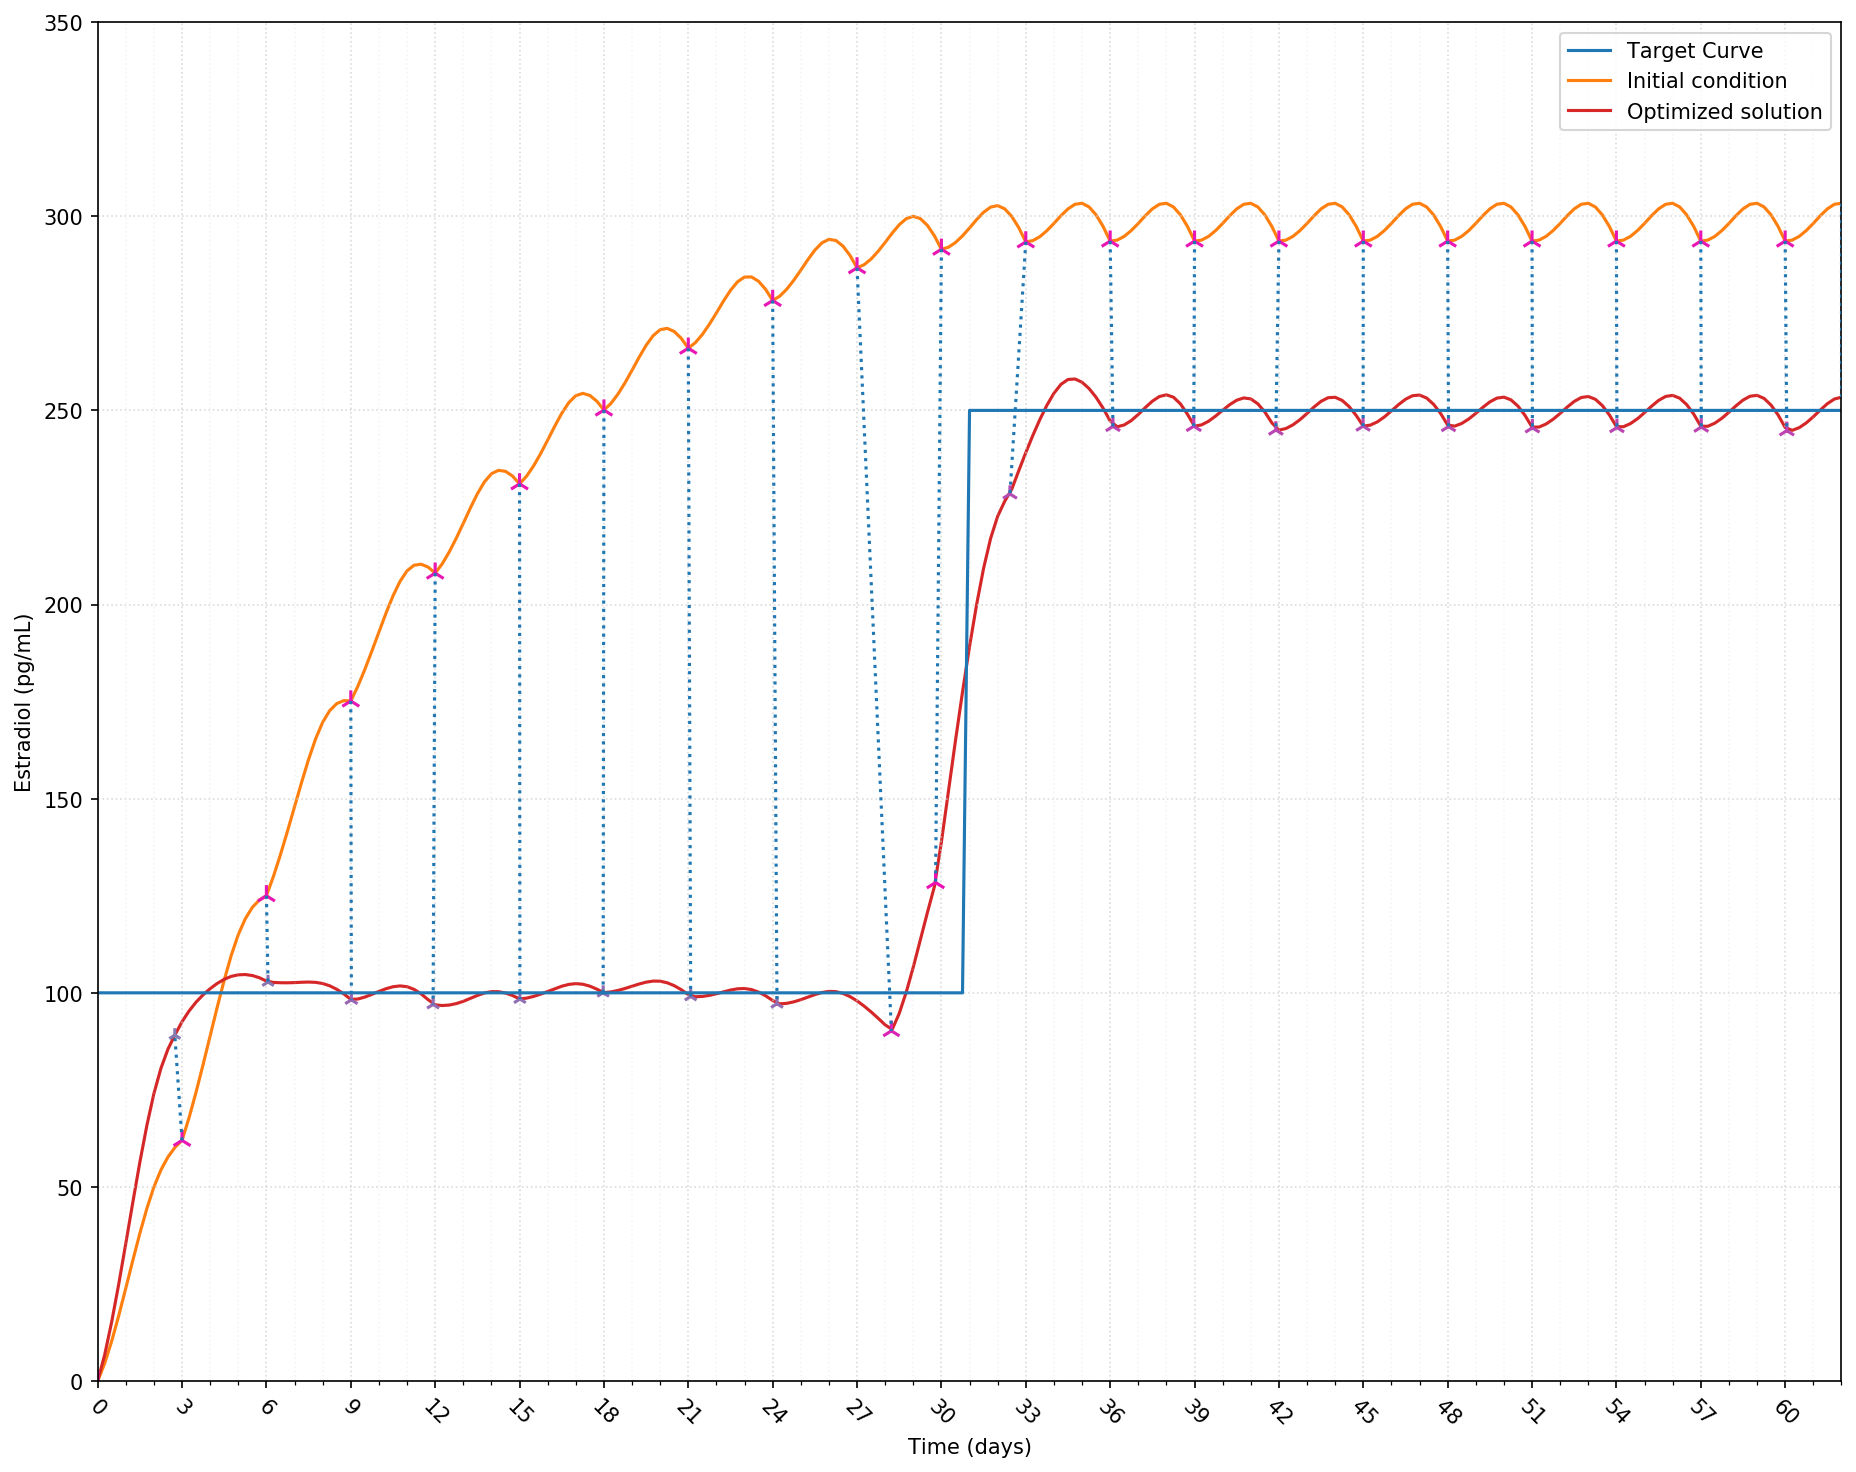

In [27]:
injections_init = injectio.createInjectionsCycle(ef_ec_1mg, 62.0, '3D')
start_y = injectio.calcInjections(pd.Series(np.zeros(len(flat_x)), index=flat_x), injections_init)
injections_optim = createInjectionsDosesTimes(result.x, ef_ec_1mg)
injections_optim[injections_init.index[-1]] = injections_init[-1]

with np.printoptions(precision=2, suppress=True):
    print(injections_optim)

init_levels = injectio.calcInjections(injectio.zeroLevelsAtInjections(injections_init),
                             injections_init)
init_points = [(injectio.timeDeltaToDays(T - init_levels.index[0]), d) for T,d in init_levels.items()]

optim_levels = injectio.calcInjections(injectio.zeroLevelsAtInjections(injections_optim),
                              injections_optim)
optim_points = [(injectio.timeDeltaToDays(T - init_levels.index[0]), d) for T,d in optim_levels.items()]

lines = list(zip(init_points, optim_points))

injectio.startPlot()
plt.ylim(bottom=0, top=350)
plt.yticks(range(0, 351, 50))
plt.plot([injectio.timeDeltaToDays(x - flat_x[0]) for x in flat_x], flat_y, label="Target Curve")
injectio.plotInjections(injections_init, '6H', label="Initial condition")
injectio.plotInjections(injections_optim, '6H', label="Optimized solution")
from matplotlib import collections as mc
lc = mc.LineCollection(lines, linestyles='dotted', zorder=10)
plt.gca().add_collection(lc);
plt.legend();

### Differential Evolution

This doesn't currently work, and I don't understand why it fails. Least squares seems to work just fine, though.

In [ ]:
injections = injectio.createInjectionsCycle(ef_ec_1mg, 62.0, '3D')
X0, bounds = createInitialAndBounds(injections, 5.0)
result = differential_evolution(fDosesAndTimes, Bounds(bounds[0], bounds[1]),
                                args=(ef_ec_1mg, target_x, target_y),
                                callback=callback)
print(result)